In [1]:
import torch
from torch import nn
from d2l import torch as d2l

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

num_inputs, num_outputs, num_hiddens = 784, 10, 256

W1 = nn.Parameter(torch.randn(num_inputs, num_hiddens, requires_grad=True))
b1 = nn.Parameter(torch.zeros(num_hiddens, requires_grad=True))
W2 = nn.Parameter(torch.randn(num_hiddens, num_outputs, requires_grad=True))
b2 = nn.Parameter(torch.zeros(num_outputs, requires_grad=True))

params = [W1, b1, W2, b2]

def relu(X):
    a = torch.zeros_like(X)
    return torch.max(X, a)

def net(X):
    X = X.reshape((-1, num_inputs))
    H = relu(X @ W1 + b1)
    return H @ W2 + b2

loss = nn.CrossEntropyLoss()


In [14]:
def accuracy(y_hat, y):
    """计算预测正确的数量。"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1) # 返回每个样本的预测类别索引,也就是概率最大的下标
    cmp = y_hat.type(y.dtype) == y   # 返回一个张量,cmp[i]的值为第i个样本是否正确,此案例中为 tensor([True, False])
    return float(cmp.type(y.dtype).sum()) # 返回 true的个数
class Animator:
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None, ylim=None, 
                 xsScale='linear', ysScale='linear', fmt=('-', 'm-', 'g-', 'r:'), 
                 nrows=1, ncols=1, figsize=(3.5, 2.5)):
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes]
        self.config_axes = lambda: d2l.set_axes(self.axes[0], xlabel, ylabel, xlim, ylim, 
                                                 xsScale, ysScale, legend)
        self.x, self.y, self.fmt = None, None, fmt

    def add(self, x, y):
        if not hasattr(y, "_len__"):
            y = [y]
        n = len(y)
        self.x = x
        self.y = y
        self.config_axes()
        self.axes[0].plot(self.x, self.y, self.fmt)
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 1],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
        train_loss, train_acc = train_metrics
    return train_loss, train_acc
def train_epoch_ch3(net, train_iter, loss, updater):
    if isinstance(net, torch.nn.Module):
        net.train()
    metric = Accumulator(3)
    for X, y in train_iter:
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            updater.step()
            metric.add(float(l) * len(y), accuracy(y_hat, y), y.size().numel())
        else:
            l.sum().backward()
            updater(X.shape[0])
            metric.add(float(l.sum()), accuracy(y_hat, y), y.size().numel())
    return metric[0] / metric[2], metric[1] / metric[2]
class Accumulator:
    """在 `n` 个变量上累加。"""
    
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]
def evaluate_accuracy(net, data_iter):
    """计算在指定数据集上模型的精度。"""
    if isinstance(net, torch.nn.Module):
        net.eval()  # 将模型设置为评估模式
    metric = Accumulator(2)  # 正确预测数、预测总数
    for X, y in data_iter:
        metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]
def cross_entropy(y_hat, y):
    return -torch.log(y_hat[range(len(y_hat)), y]) #返回的是每个样本的交叉熵损失值

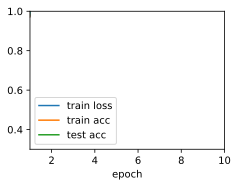

In [15]:
# 设置训练参数
num_epochs, lr = 10, 0.1
updater = torch.optim.SGD(params, lr=lr)

# 使用d2l提供的训练函数
train_ch3(net, train_iter, test_iter, loss, num_epochs, updater)

# 使用nn.Sequential定义模型
net = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 256),
    nn.ReLU(),
    nn.Linear(256, 10)
)




In [16]:
import torch
from torch import nn
from d2l import torch as d2l
net = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 256),
    nn.ReLU(),
    nn.Linear(256, 10)
)

# 初始化权重
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights);

(0.3801426774342855, 0.8659833333333333)

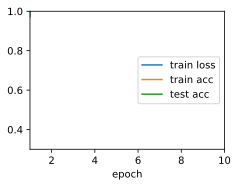

In [18]:
batch_size, lr, num_epochs = 256, 0.1, 10
loss = nn.CrossEntropyLoss()
trainer = torch.optim.SGD(net.parameters(), lr=lr)

train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)
